In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # For progress bars
import time
import copy # To copy model state for fair comparison start
import random

In [ ]:
# Check for GPU availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}") # Print selected device to ensure it's correct

Using device: cuda


In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100 # Keep epochs, augmentation might require longer training
RANDOM_SEED = 42 # For reproducibility

In [ ]:
# PatchShuffle specific parameters
PATCH_SHUFFLE_PROBABILITY = 0.3 # Apply PatchShuffle to 30% of images
PATCH_SHUFFLE_PATCH_SIZE = (4, 4) # Use 4x4 patches

In [ ]:
torch.manual_seed(RANDOM_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED) # For python's random used in PatchShuffle probability check

In [ ]:
# CIFAR-10 standard normalization
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)

In [ ]:
# --- 2. PatchShuffle Implementation ---

def patch_shuffle(img_np, patch_size=(4, 4), probability=0.5):
    """
    Applies random pixel shuffling within non-overlapping patches of a NumPy image array.
    Handles non-divisible image sizes by ignoring border pixels.

    Args:
        img_np (np.ndarray): Input image as a NumPy array (H, W, C).
        patch_size (tuple): Height and width of the patches.
        probability (float): Probability of applying the shuffle to the image.

    Returns:
        np.ndarray: Image with pixels potentially shuffled within patches.
    """
    if random.random() > probability:
        return img_np # Apply only with a certain probability

    h, w, c = img_np.shape
    ph, pw = patch_size

    # Calculate effective height and width that are divisible
    eff_h = h - (h % ph)
    eff_w = w - (w % pw)

    if eff_h == 0 or eff_w == 0:
        print(f"Warning: Effective dimensions ({eff_h},{eff_w}) are zero for patch size ({ph},{pw}). Skipping shuffle.")
        return img_np

    # Work only on the top-left part of the image that is divisible
    target_view = img_np[:eff_h, :eff_w, :]

    # Check if target_view is contiguous and make it so if necessary
    if not target_view.flags['C_CONTIGUOUS']:
        target_view = np.ascontiguousarray(target_view)


    # Reshape into patches: (NumPatchesH, NumPatchesW, PatchH, PatchW, Channels)
    try:
        patches = target_view.reshape(eff_h // ph, ph, eff_w // pw, pw, c)
        patches = patches.transpose(0, 2, 1, 3, 4) # -> (NumPatchesH, NumPatchesW, PatchH, PatchW, Channels)
        patches = patches.reshape(-1, ph, pw, c)  # -> (TotalNumPatches, PatchH, PatchW, Channels)
    except ValueError as e:
        print(f"Error reshaping image with shape {target_view.shape} for patch size {patch_size}. Error: {e}")
        return img_np # Return original if reshape fails

    # Shuffle pixels within each patch
    for i in range(patches.shape[0]):
        patch = patches[i]
        # Flatten pixels per channel, shuffle, reshape back
        pixels = patch.reshape(-1, c) # (PatchH * PatchW, Channels)
        np.random.shuffle(pixels) # Shuffles along the first axis (rows)
        patches[i] = pixels.reshape(ph, pw, c)

    # Reshape back to image format (this modifies the target_view in place if possible)
    patches = patches.reshape(eff_h // ph, eff_w // pw, ph, pw, c)
    patches = patches.transpose(0, 2, 1, 3, 4) # -> (NumPatchesH, PatchH, NumPatchesW, PatchW, Channels)
    # This assignment writes the shuffled data back into the original array's memory (via target_view)
    target_view[...] = patches.reshape(eff_h, eff_w, c)

    return img_np # Return the modified original array

In [ ]:
# --- Wrapper Class for PyTorch Transforms ---
class PatchShuffleTransform:
    def __init__(self, patch_size=(4, 4), probability=0.5):
        self.patch_size = patch_size
        self.probability = probability

    def __call__(self, img_tensor):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Patch shuffled image.
        """
        # Convert tensor to NumPy (C, H, W) -> (H, W, C)
        # Ensure numpy uses float32 or float64, but shuffling doesn't strictly require float
        img_np = img_tensor.permute(1, 2, 0).contiguous().numpy()

        # Apply the shuffle (make a copy to ensure writability if needed)
        # Using copy() is safer if the tensor comes from a non-writable source
        shuffled_img_np = patch_shuffle(np.copy(img_np), self.patch_size, self.probability)

        # Convert back to tensor (H, W, C) -> (C, H, W)
        shuffled_img_tensor = torch.from_numpy(shuffled_img_np).permute(2, 0, 1)
        return shuffled_img_tensor

In [ ]:
# --- 3. Data Augmentation Definitions ---

# Transforms WITHOUT augmentation
transform_plain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

In [ ]:
# Transforms WITH  Augmentation (Sec 2.1, 2.2 + PatchShuffle)
transform_augmented = transforms.Compose([
    # Section 2.1 (Applied to PIL Image)
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    # Convert to Tensor
    transforms.ToTensor(),

    # Section 2.1 + New Method (Applied to Tensor)
    PatchShuffleTransform(patch_size=PATCH_SHUFFLE_PATCH_SIZE, probability=PATCH_SHUFFLE_PROBABILITY),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0, inplace=False), # Erase after shuffle

    # Standard Normalization (Applied last)
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

In [ ]:
# --- 4. Load Datasets ---
from torch.utils.data import random_split
# Load datasets once for basic info
try:
    train_dataset_info = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    train_size = int(0.9 * len(train_dataset_info))  # 45000
    val_size = len(train_dataset_info) - train_size  # 5000
    test_dataset_info = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    classes = train_dataset_info.classes
    print(f"CIFAR-10 classes: {classes}")
except Exception as e:
    print(f"Error downloading/loading CIFAR-10 dataset: {e}")
    print("Please check your internet connection or disk permissions.")
    exit()

100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Datasets with specific transforms
train_dataset_plain = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_plain)
train_dataset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_augmented) # Use the new combined transform
train_dataset_augmented_final, val_dataset_augmented_final = random_split(train_dataset_augmented, [train_size, val_size])
train_dataset_plain_final, val_dataset_plain_final = random_split(train_dataset_plain, [train_size, val_size])
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=False, transform=transform_plain) # Test set usually doesn't have augmentation

In [ ]:
# --- 5. Data Loaders ---

train_loader_plain = DataLoader(train_dataset_plain_final, batch_size=BATCH_SIZE,
                                shuffle=True, num_workers=2, pin_memory=True if DEVICE=='cuda' else False)
train_loader_augmented = DataLoader(train_dataset_augmented_final, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=2, pin_memory=True if DEVICE=='cuda' else False)
val_loader_plain = DataLoader(val_dataset_plain_final, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=2, pin_memory=True if DEVICE=='cuda' else False)
#val_loader_augmented = DataLoader(val_dataset_augmented_final, batch_size=BATCH_SIZE,shuffle=False, num_workers=2, pin_memory=True if DEVICE=='cuda' else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2, pin_memory=True if DEVICE=='cuda' else False)

In [ ]:
# --- 6. Simple CNN Model Definition  ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# --- 7. Training and Evaluation Functions (Simplified) ---

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels) # Standard loss calculation

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item() # Standard accuracy calculation

        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [ ]:
# Evaluation function remains the same
def evaluate(model, test_loader, criterion, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(test_loader, desc="Evaluating", leave=False)
    with torch.no_grad(): # No need to track gradients during evaluation
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels) # Standard criterion

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

In [ ]:
# --- 8. Main Training and Comparison Logic ---

def run_experiment(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """Runs a full training and validation experiment (test after training)."""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}  | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"*** New best validation accuracy: {best_val_acc:.4f} ***")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTraining finished in {total_time // 60:.0f}m {total_time % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history


In [ ]:
# --- Experiment 1: Without Any Data Augmentation ---
print("\n--- Starting Experiment: WITHOUT Data Augmentation ---")
model_plain = SimpleCNN(num_classes=len(classes))
initial_state_dict = copy.deepcopy(model_plain.state_dict())  # Save initial weights

# Run experiment with training and validation loaders
model_plain_trained, history_plain = run_experiment(
    model=model_plain,
    train_loader=train_loader_plain,
    val_loader=val_loader_plain,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)

# Final evaluation on test set after training
test_loss_plain, test_acc_plain = evaluate(model_plain_trained, test_loader, nn.CrossEntropyLoss(), DEVICE)
print(f"Final Test Accuracy (without augmentation): {test_acc_plain:.4f}")


--- Starting Experiment: WITHOUT Data Augmentation ---

Epoch 1/100


Train Loss: 1.3907 | Train Acc: 0.4950
Val Loss: 1.0093  | Val Acc: 0.6414
*** New best validation accuracy: 0.6414 ***

Epoch 2/100


Train Loss: 1.0097 | Train Acc: 0.6417
Val Loss: 0.9866  | Val Acc: 0.6586
*** New best validation accuracy: 0.6586 ***

Epoch 3/100


Train Loss: 0.8708 | Train Acc: 0.6904
Val Loss: 0.7688  | Val Acc: 0.7312
*** New best validation accuracy: 0.7312 ***

Epoch 4/100


Train Loss: 0.7697 | Train Acc: 0.7308
Val Loss: 0.7043  | Val Acc: 0.7540
*** New best validation accuracy: 0.7540 ***

Epoch 5/100


Train Loss: 0.7091 | Train Acc: 0.7502
Val Loss: 0.7280  | Val Acc: 0.7436

Epoch 6/100


Train Loss: 0.6500 | Train Acc: 0.7688
Val Loss: 0.7161  | Val Acc: 0.7492

Epoch 7/100


Train Loss: 0.5875 | Train Acc: 0.7935
Val Loss: 0.6904  | Val Acc: 0.7576
*** New best validation accuracy: 0.7576 ***

Epoch 8/100


Train Loss: 0.5431 | Train Acc: 0.8099
Val Loss: 0.6491  | Val Acc: 0.7764
*** New best validation accuracy: 0.7764 ***

Epoch 9/100


Train Loss: 0.5007 | Train Acc: 0.8223
Val Loss: 0.6461  | Val Acc: 0.7806
*** New best validation accuracy: 0.7806 ***

Epoch 10/100


Train Loss: 0.4627 | Train Acc: 0.8367
Val Loss: 0.6451  | Val Acc: 0.7888
*** New best validation accuracy: 0.7888 ***

Epoch 11/100


Train Loss: 0.4194 | Train Acc: 0.8526
Val Loss: 0.6564  | Val Acc: 0.7808

Epoch 12/100


Train Loss: 0.3822 | Train Acc: 0.8630
Val Loss: 0.6820  | Val Acc: 0.7760

Epoch 13/100


Train Loss: 0.3533 | Train Acc: 0.8737
Val Loss: 0.6746  | Val Acc: 0.7870

Epoch 14/100


Train Loss: 0.3229 | Train Acc: 0.8843
Val Loss: 0.6260  | Val Acc: 0.8042
*** New best validation accuracy: 0.8042 ***

Epoch 15/100


Train Loss: 0.2968 | Train Acc: 0.8956
Val Loss: 0.6579  | Val Acc: 0.7982

Epoch 16/100


Train Loss: 0.2753 | Train Acc: 0.9015
Val Loss: 0.6813  | Val Acc: 0.7994

Epoch 17/100


Train Loss: 0.2532 | Train Acc: 0.9086
Val Loss: 0.7128  | Val Acc: 0.7906

Epoch 18/100


Train Loss: 0.2296 | Train Acc: 0.9174
Val Loss: 0.7412  | Val Acc: 0.7922

Epoch 19/100


Train Loss: 0.2148 | Train Acc: 0.9226
Val Loss: 0.7608  | Val Acc: 0.7996

Epoch 20/100


Train Loss: 0.1993 | Train Acc: 0.9282
Val Loss: 0.8100  | Val Acc: 0.7922

Epoch 21/100


Train Loss: 0.1811 | Train Acc: 0.9356
Val Loss: 0.7525  | Val Acc: 0.8020

Epoch 22/100


Train Loss: 0.1742 | Train Acc: 0.9373
Val Loss: 0.7602  | Val Acc: 0.8056
*** New best validation accuracy: 0.8056 ***

Epoch 23/100


Train Loss: 0.1627 | Train Acc: 0.9412
Val Loss: 0.8168  | Val Acc: 0.8030

Epoch 24/100


Train Loss: 0.1586 | Train Acc: 0.9432
Val Loss: 0.8671  | Val Acc: 0.7930

Epoch 25/100


Train Loss: 0.1476 | Train Acc: 0.9475
Val Loss: 0.9284  | Val Acc: 0.7854

Epoch 26/100


Train Loss: 0.1389 | Train Acc: 0.9492
Val Loss: 0.8919  | Val Acc: 0.8004

Epoch 27/100


Train Loss: 0.1281 | Train Acc: 0.9552
Val Loss: 0.9701  | Val Acc: 0.7798

Epoch 28/100


Train Loss: 0.1264 | Train Acc: 0.9561
Val Loss: 0.9372  | Val Acc: 0.8006

Epoch 29/100


Train Loss: 0.1083 | Train Acc: 0.9620
Val Loss: 0.9215  | Val Acc: 0.8044

Epoch 30/100


Train Loss: 0.1137 | Train Acc: 0.9600
Val Loss: 0.9622  | Val Acc: 0.7990

Epoch 31/100


Train Loss: 0.1168 | Train Acc: 0.9594
Val Loss: 0.9484  | Val Acc: 0.8018

Epoch 32/100


Train Loss: 0.1097 | Train Acc: 0.9617
Val Loss: 1.0503  | Val Acc: 0.7984

Epoch 33/100


Train Loss: 0.1063 | Train Acc: 0.9633
Val Loss: 0.9627  | Val Acc: 0.8006

Epoch 34/100


Train Loss: 0.1068 | Train Acc: 0.9626
Val Loss: 1.0777  | Val Acc: 0.7922

Epoch 35/100


Train Loss: 0.0925 | Train Acc: 0.9678
Val Loss: 1.0034  | Val Acc: 0.7968

Epoch 36/100


Train Loss: 0.0880 | Train Acc: 0.9682
Val Loss: 1.0072  | Val Acc: 0.8012

Epoch 37/100


Train Loss: 0.0866 | Train Acc: 0.9699
Val Loss: 1.0564  | Val Acc: 0.7958

Epoch 38/100


Train Loss: 0.0908 | Train Acc: 0.9683
Val Loss: 0.9803  | Val Acc: 0.8010

Epoch 39/100


Train Loss: 0.0852 | Train Acc: 0.9701
Val Loss: 1.0846  | Val Acc: 0.7968

Epoch 40/100


Train Loss: 0.0803 | Train Acc: 0.9721
Val Loss: 1.0664  | Val Acc: 0.7958

Epoch 41/100


Train Loss: 0.0731 | Train Acc: 0.9748
Val Loss: 1.2226  | Val Acc: 0.7862

Epoch 42/100


Train Loss: 0.0874 | Train Acc: 0.9692
Val Loss: 1.1542  | Val Acc: 0.7850

Epoch 43/100


Train Loss: 0.0771 | Train Acc: 0.9736
Val Loss: 1.1678  | Val Acc: 0.8034

Epoch 44/100


Train Loss: 0.0791 | Train Acc: 0.9732
Val Loss: 1.2388  | Val Acc: 0.7940

Epoch 45/100


Train Loss: 0.0757 | Train Acc: 0.9737
Val Loss: 1.1250  | Val Acc: 0.8040

Epoch 46/100


Train Loss: 0.0651 | Train Acc: 0.9770
Val Loss: 1.1908  | Val Acc: 0.7918

Epoch 47/100


Train Loss: 0.0743 | Train Acc: 0.9748
Val Loss: 1.1300  | Val Acc: 0.8038

Epoch 48/100


Train Loss: 0.0683 | Train Acc: 0.9758
Val Loss: 1.1820  | Val Acc: 0.7946

Epoch 49/100


Train Loss: 0.0726 | Train Acc: 0.9748
Val Loss: 1.2240  | Val Acc: 0.7898

Epoch 50/100


Train Loss: 0.0660 | Train Acc: 0.9779
Val Loss: 1.2637  | Val Acc: 0.7960

Epoch 51/100


Train Loss: 0.0693 | Train Acc: 0.9763
Val Loss: 1.1269  | Val Acc: 0.8004

Epoch 52/100


Train Loss: 0.0679 | Train Acc: 0.9772
Val Loss: 1.1422  | Val Acc: 0.7970

Epoch 53/100


Train Loss: 0.0698 | Train Acc: 0.9759
Val Loss: 1.2608  | Val Acc: 0.7952

Epoch 54/100


Train Loss: 0.0658 | Train Acc: 0.9774
Val Loss: 1.1905  | Val Acc: 0.7952

Epoch 55/100


Train Loss: 0.0570 | Train Acc: 0.9804
Val Loss: 1.4015  | Val Acc: 0.7892

Epoch 56/100


Train Loss: 0.0612 | Train Acc: 0.9791
Val Loss: 1.2400  | Val Acc: 0.8012

Epoch 57/100


Train Loss: 0.0643 | Train Acc: 0.9785
Val Loss: 1.2128  | Val Acc: 0.7962

Epoch 58/100


Train Loss: 0.0573 | Train Acc: 0.9807
Val Loss: 1.2030  | Val Acc: 0.8052

Epoch 59/100


Train Loss: 0.0608 | Train Acc: 0.9785
Val Loss: 1.2444  | Val Acc: 0.7966

Epoch 60/100


Train Loss: 0.0551 | Train Acc: 0.9806
Val Loss: 1.2122  | Val Acc: 0.7990

Epoch 61/100


Train Loss: 0.0607 | Train Acc: 0.9791
Val Loss: 1.3860  | Val Acc: 0.7898

Epoch 62/100


Train Loss: 0.0595 | Train Acc: 0.9796
Val Loss: 1.3108  | Val Acc: 0.7994

Epoch 63/100


Train Loss: 0.0535 | Train Acc: 0.9817
Val Loss: 1.2290  | Val Acc: 0.8010

Epoch 64/100


Train Loss: 0.0545 | Train Acc: 0.9815
Val Loss: 1.2914  | Val Acc: 0.8024

Epoch 65/100


Train Loss: 0.0550 | Train Acc: 0.9813
Val Loss: 1.3604  | Val Acc: 0.7982

Epoch 66/100


Train Loss: 0.0510 | Train Acc: 0.9826
Val Loss: 1.3234  | Val Acc: 0.7946

Epoch 67/100


Train Loss: 0.0527 | Train Acc: 0.9821
Val Loss: 1.3187  | Val Acc: 0.7996

Epoch 68/100


Train Loss: 0.0537 | Train Acc: 0.9811
Val Loss: 1.3630  | Val Acc: 0.7964

Epoch 69/100


Train Loss: 0.0514 | Train Acc: 0.9828
Val Loss: 1.4475  | Val Acc: 0.7840

Epoch 70/100


Train Loss: 0.0531 | Train Acc: 0.9821
Val Loss: 1.4198  | Val Acc: 0.7940

Epoch 71/100


Train Loss: 0.0525 | Train Acc: 0.9814
Val Loss: 1.3344  | Val Acc: 0.8028

Epoch 72/100


Train Loss: 0.0480 | Train Acc: 0.9838
Val Loss: 1.3537  | Val Acc: 0.7960

Epoch 73/100


Train Loss: 0.0489 | Train Acc: 0.9836
Val Loss: 1.3550  | Val Acc: 0.7946

Epoch 74/100


Train Loss: 0.0452 | Train Acc: 0.9842
Val Loss: 1.4648  | Val Acc: 0.7992

Epoch 75/100


Train Loss: 0.0493 | Train Acc: 0.9829
Val Loss: 1.3384  | Val Acc: 0.7938

Epoch 76/100


Train Loss: 0.0473 | Train Acc: 0.9839
Val Loss: 1.3587  | Val Acc: 0.7960

Epoch 77/100


Train Loss: 0.0491 | Train Acc: 0.9840
Val Loss: 1.3520  | Val Acc: 0.7912

Epoch 78/100


Train Loss: 0.0483 | Train Acc: 0.9837
Val Loss: 1.3873  | Val Acc: 0.7972

Epoch 79/100


Train Loss: 0.0461 | Train Acc: 0.9841
Val Loss: 1.4090  | Val Acc: 0.8042

Epoch 80/100


Train Loss: 0.0497 | Train Acc: 0.9834
Val Loss: 1.4050  | Val Acc: 0.7920

Epoch 81/100


Train Loss: 0.0407 | Train Acc: 0.9859
Val Loss: 1.4060  | Val Acc: 0.7980

Epoch 82/100


Train Loss: 0.0475 | Train Acc: 0.9848
Val Loss: 1.3289  | Val Acc: 0.7998

Epoch 83/100


Train Loss: 0.0492 | Train Acc: 0.9833
Val Loss: 1.4898  | Val Acc: 0.7878

Epoch 84/100


Train Loss: 0.0410 | Train Acc: 0.9863
Val Loss: 1.4408  | Val Acc: 0.7958

Epoch 85/100


Train Loss: 0.0455 | Train Acc: 0.9849
Val Loss: 1.4567  | Val Acc: 0.7942

Epoch 86/100


Train Loss: 0.0470 | Train Acc: 0.9837
Val Loss: 1.3891  | Val Acc: 0.7946

Epoch 87/100


Train Loss: 0.0394 | Train Acc: 0.9862
Val Loss: 1.3611  | Val Acc: 0.7994

Epoch 88/100


Train Loss: 0.0375 | Train Acc: 0.9872
Val Loss: 1.5485  | Val Acc: 0.7964

Epoch 89/100


Train Loss: 0.0419 | Train Acc: 0.9861
Val Loss: 1.5904  | Val Acc: 0.7874

Epoch 90/100


Train Loss: 0.0468 | Train Acc: 0.9845
Val Loss: 1.5160  | Val Acc: 0.7900

Epoch 91/100


Train Loss: 0.0459 | Train Acc: 0.9845
Val Loss: 1.4972  | Val Acc: 0.7944

Epoch 92/100


Train Loss: 0.0338 | Train Acc: 0.9888
Val Loss: 1.5063  | Val Acc: 0.7938

Epoch 93/100


Train Loss: 0.0426 | Train Acc: 0.9856
Val Loss: 1.5747  | Val Acc: 0.7910

Epoch 94/100


Train Loss: 0.0373 | Train Acc: 0.9870
Val Loss: 1.4978  | Val Acc: 0.7938

Epoch 95/100


Train Loss: 0.0444 | Train Acc: 0.9850
Val Loss: 1.4541  | Val Acc: 0.8020

Epoch 96/100


Train Loss: 0.0394 | Train Acc: 0.9870
Val Loss: 1.5664  | Val Acc: 0.7918

Epoch 97/100


Train Loss: 0.0393 | Train Acc: 0.9865
Val Loss: 1.5145  | Val Acc: 0.7882

Epoch 98/100


Train Loss: 0.0373 | Train Acc: 0.9875
Val Loss: 1.4882  | Val Acc: 0.7908

Epoch 99/100


Train Loss: 0.0376 | Train Acc: 0.9876
Val Loss: 1.4510  | Val Acc: 0.7936

Epoch 100/100


Train Loss: 0.0363 | Train Acc: 0.9872
Val Loss: 1.4935  | Val Acc: 0.7946

Training finished in 22m 27s
Best Validation Accuracy: 0.8056


Final Test Accuracy (without augmentation): 0.7914


In [ ]:
# --- Experiment 2: With Combined Data Augmentation (Base + PatchShuffle) ---
print("\n--- Starting Experiment: WITH Data Augmentation (Base + PatchShuffle) ---")

# Initialize the model and reset weights
model_augmented = SimpleCNN(num_classes=len(classes))
model_augmented.load_state_dict(initial_state_dict)  # Reset weights to be fair

# Run the experiment with combined data augmentation
model_augmented_trained, history_augmented = run_experiment(
    model=model_augmented,
    train_loader=train_loader_augmented,  # Use the loader with combined augmentations
    val_loader=val_loader_plain,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)

# Final evaluation on test set after training
test_loss_augmented, test_acc_augmented = evaluate(model_augmented_trained, test_loader, nn.CrossEntropyLoss(), DEVICE)
print(f"Final Test Accuracy (with augmentation): {test_acc_augmented:.4f}")



--- Starting Experiment: WITH Data Augmentation (Base + PatchShuffle) ---

Epoch 1/100


Train Loss: 1.7399 | Train Acc: 0.3615
Val Loss: 1.3656  | Val Acc: 0.5064
*** New best validation accuracy: 0.5064 ***

Epoch 2/100


Train Loss: 1.4964 | Train Acc: 0.4548
Val Loss: 1.1747  | Val Acc: 0.5804
*** New best validation accuracy: 0.5804 ***

Epoch 3/100


Train Loss: 1.3880 | Train Acc: 0.4973
Val Loss: 1.0580  | Val Acc: 0.6202
*** New best validation accuracy: 0.6202 ***

Epoch 4/100


Train Loss: 1.3116 | Train Acc: 0.5267
Val Loss: 0.9492  | Val Acc: 0.6598
*** New best validation accuracy: 0.6598 ***

Epoch 5/100


Train Loss: 1.2610 | Train Acc: 0.5539
Val Loss: 0.9129  | Val Acc: 0.6648
*** New best validation accuracy: 0.6648 ***

Epoch 6/100


Train Loss: 1.2152 | Train Acc: 0.5670
Val Loss: 0.8607  | Val Acc: 0.6938
*** New best validation accuracy: 0.6938 ***

Epoch 7/100


Train Loss: 1.1820 | Train Acc: 0.5823
Val Loss: 0.8119  | Val Acc: 0.7126
*** New best validation accuracy: 0.7126 ***

Epoch 8/100


Train Loss: 1.1520 | Train Acc: 0.5921
Val Loss: 0.7659  | Val Acc: 0.7358
*** New best validation accuracy: 0.7358 ***

Epoch 9/100


Train Loss: 1.1265 | Train Acc: 0.6002
Val Loss: 0.7632  | Val Acc: 0.7264

Epoch 10/100


Train Loss: 1.1085 | Train Acc: 0.6092
Val Loss: 0.7404  | Val Acc: 0.7414
*** New best validation accuracy: 0.7414 ***

Epoch 11/100


Train Loss: 1.0828 | Train Acc: 0.6194
Val Loss: 0.6860  | Val Acc: 0.7584
*** New best validation accuracy: 0.7584 ***

Epoch 12/100


Train Loss: 1.0668 | Train Acc: 0.6252
Val Loss: 0.7210  | Val Acc: 0.7446

Epoch 13/100


Train Loss: 1.0450 | Train Acc: 0.6353
Val Loss: 0.6657  | Val Acc: 0.7696
*** New best validation accuracy: 0.7696 ***

Epoch 14/100


Train Loss: 1.0330 | Train Acc: 0.6374
Val Loss: 0.6293  | Val Acc: 0.7778
*** New best validation accuracy: 0.7778 ***

Epoch 15/100


Train Loss: 1.0200 | Train Acc: 0.6441
Val Loss: 0.6272  | Val Acc: 0.7856
*** New best validation accuracy: 0.7856 ***

Epoch 16/100


Train Loss: 0.9962 | Train Acc: 0.6530
Val Loss: 0.6247  | Val Acc: 0.7780

Epoch 17/100


Train Loss: 0.9882 | Train Acc: 0.6544
Val Loss: 0.6285  | Val Acc: 0.7794

Epoch 18/100


Train Loss: 0.9727 | Train Acc: 0.6593
Val Loss: 0.5883  | Val Acc: 0.7974
*** New best validation accuracy: 0.7974 ***

Epoch 19/100


Train Loss: 0.9709 | Train Acc: 0.6615
Val Loss: 0.5842  | Val Acc: 0.7978
*** New best validation accuracy: 0.7978 ***

Epoch 20/100


Train Loss: 0.9587 | Train Acc: 0.6641
Val Loss: 0.5683  | Val Acc: 0.8008
*** New best validation accuracy: 0.8008 ***

Epoch 21/100


Train Loss: 0.9444 | Train Acc: 0.6706
Val Loss: 0.5726  | Val Acc: 0.7956

Epoch 22/100


Train Loss: 0.9407 | Train Acc: 0.6710
Val Loss: 0.5395  | Val Acc: 0.8132
*** New best validation accuracy: 0.8132 ***

Epoch 23/100


Train Loss: 0.9261 | Train Acc: 0.6778
Val Loss: 0.5356  | Val Acc: 0.8134
*** New best validation accuracy: 0.8134 ***

Epoch 24/100


Train Loss: 0.9224 | Train Acc: 0.6782
Val Loss: 0.5681  | Val Acc: 0.8032

Epoch 25/100


Train Loss: 0.9111 | Train Acc: 0.6847
Val Loss: 0.5527  | Val Acc: 0.8060

Epoch 26/100


Train Loss: 0.9036 | Train Acc: 0.6864
Val Loss: 0.5287  | Val Acc: 0.8142
*** New best validation accuracy: 0.8142 ***

Epoch 27/100


Train Loss: 0.8987 | Train Acc: 0.6878
Val Loss: 0.5130  | Val Acc: 0.8286
*** New best validation accuracy: 0.8286 ***

Epoch 28/100


Train Loss: 0.8866 | Train Acc: 0.6938
Val Loss: 0.5105  | Val Acc: 0.8244

Epoch 29/100


Train Loss: 0.8869 | Train Acc: 0.6909
Val Loss: 0.4966  | Val Acc: 0.8246

Epoch 30/100


Train Loss: 0.8783 | Train Acc: 0.6970
Val Loss: 0.4989  | Val Acc: 0.8286

Epoch 31/100


Train Loss: 0.8775 | Train Acc: 0.6944
Val Loss: 0.5207  | Val Acc: 0.8140

Epoch 32/100


Train Loss: 0.8612 | Train Acc: 0.7014
Val Loss: 0.4837  | Val Acc: 0.8310
*** New best validation accuracy: 0.8310 ***

Epoch 33/100


Train Loss: 0.8580 | Train Acc: 0.7017
Val Loss: 0.4706  | Val Acc: 0.8390
*** New best validation accuracy: 0.8390 ***

Epoch 34/100


Train Loss: 0.8504 | Train Acc: 0.7033
Val Loss: 0.4905  | Val Acc: 0.8320

Epoch 35/100


Train Loss: 0.8503 | Train Acc: 0.7042
Val Loss: 0.4767  | Val Acc: 0.8332

Epoch 36/100


Train Loss: 0.8379 | Train Acc: 0.7087
Val Loss: 0.4448  | Val Acc: 0.8478
*** New best validation accuracy: 0.8478 ***

Epoch 37/100


Train Loss: 0.8442 | Train Acc: 0.7094
Val Loss: 0.4526  | Val Acc: 0.8414

Epoch 38/100


Train Loss: 0.8375 | Train Acc: 0.7109
Val Loss: 0.4542  | Val Acc: 0.8462

Epoch 39/100


Train Loss: 0.8364 | Train Acc: 0.7108
Val Loss: 0.4570  | Val Acc: 0.8400

Epoch 40/100


Train Loss: 0.8267 | Train Acc: 0.7125
Val Loss: 0.4654  | Val Acc: 0.8376

Epoch 41/100


Train Loss: 0.8277 | Train Acc: 0.7130
Val Loss: 0.4531  | Val Acc: 0.8420

Epoch 42/100


Train Loss: 0.8178 | Train Acc: 0.7189
Val Loss: 0.4636  | Val Acc: 0.8374

Epoch 43/100


Train Loss: 0.8146 | Train Acc: 0.7189
Val Loss: 0.4319  | Val Acc: 0.8518
*** New best validation accuracy: 0.8518 ***

Epoch 44/100


Train Loss: 0.8183 | Train Acc: 0.7176
Val Loss: 0.4584  | Val Acc: 0.8388

Epoch 45/100


Train Loss: 0.8103 | Train Acc: 0.7188
Val Loss: 0.4323  | Val Acc: 0.8532
*** New best validation accuracy: 0.8532 ***

Epoch 46/100


Train Loss: 0.8082 | Train Acc: 0.7212
Val Loss: 0.4087  | Val Acc: 0.8602
*** New best validation accuracy: 0.8602 ***

Epoch 47/100


Train Loss: 0.8034 | Train Acc: 0.7213
Val Loss: 0.4475  | Val Acc: 0.8452

Epoch 48/100


Train Loss: 0.8014 | Train Acc: 0.7238
Val Loss: 0.4171  | Val Acc: 0.8584

Epoch 49/100


Train Loss: 0.8043 | Train Acc: 0.7209
Val Loss: 0.4083  | Val Acc: 0.8518

Epoch 50/100


Train Loss: 0.7987 | Train Acc: 0.7219
Val Loss: 0.4157  | Val Acc: 0.8556

Epoch 51/100


Train Loss: 0.7883 | Train Acc: 0.7268
Val Loss: 0.4014  | Val Acc: 0.8606
*** New best validation accuracy: 0.8606 ***

Epoch 52/100


Train Loss: 0.7828 | Train Acc: 0.7285
Val Loss: 0.3921  | Val Acc: 0.8652
*** New best validation accuracy: 0.8652 ***

Epoch 53/100


Train Loss: 0.7849 | Train Acc: 0.7268
Val Loss: 0.4033  | Val Acc: 0.8594

Epoch 54/100


Train Loss: 0.7822 | Train Acc: 0.7286
Val Loss: 0.3940  | Val Acc: 0.8644

Epoch 55/100


Train Loss: 0.7752 | Train Acc: 0.7320
Val Loss: 0.4068  | Val Acc: 0.8558

Epoch 56/100


Train Loss: 0.7676 | Train Acc: 0.7358
Val Loss: 0.4008  | Val Acc: 0.8584

Epoch 57/100


Train Loss: 0.7761 | Train Acc: 0.7318
Val Loss: 0.3938  | Val Acc: 0.8622

Epoch 58/100


Train Loss: 0.7678 | Train Acc: 0.7373
Val Loss: 0.3785  | Val Acc: 0.8690
*** New best validation accuracy: 0.8690 ***

Epoch 59/100


Train Loss: 0.7621 | Train Acc: 0.7366
Val Loss: 0.3858  | Val Acc: 0.8634

Epoch 60/100


Train Loss: 0.7647 | Train Acc: 0.7353
Val Loss: 0.3913  | Val Acc: 0.8686

Epoch 61/100


Train Loss: 0.7604 | Train Acc: 0.7384
Val Loss: 0.3965  | Val Acc: 0.8580

Epoch 62/100


Train Loss: 0.7637 | Train Acc: 0.7365
Val Loss: 0.3814  | Val Acc: 0.8658

Epoch 63/100


Train Loss: 0.7585 | Train Acc: 0.7375
Val Loss: 0.3805  | Val Acc: 0.8716
*** New best validation accuracy: 0.8716 ***

Epoch 64/100


Train Loss: 0.7592 | Train Acc: 0.7377
Val Loss: 0.3675  | Val Acc: 0.8726
*** New best validation accuracy: 0.8726 ***

Epoch 65/100


Train Loss: 0.7545 | Train Acc: 0.7405
Val Loss: 0.3850  | Val Acc: 0.8644

Epoch 66/100


Train Loss: 0.7454 | Train Acc: 0.7394
Val Loss: 0.3592  | Val Acc: 0.8712

Epoch 67/100


Train Loss: 0.7458 | Train Acc: 0.7428
Val Loss: 0.3567  | Val Acc: 0.8732
*** New best validation accuracy: 0.8732 ***

Epoch 68/100


Train Loss: 0.7406 | Train Acc: 0.7429
Val Loss: 0.3865  | Val Acc: 0.8576

Epoch 69/100


Train Loss: 0.7419 | Train Acc: 0.7449
Val Loss: 0.3691  | Val Acc: 0.8674

Epoch 70/100


Train Loss: 0.7396 | Train Acc: 0.7436
Val Loss: 0.3523  | Val Acc: 0.8748
*** New best validation accuracy: 0.8748 ***

Epoch 71/100


Train Loss: 0.7256 | Train Acc: 0.7490
Val Loss: 0.3523  | Val Acc: 0.8714

Epoch 72/100


Train Loss: 0.7419 | Train Acc: 0.7426
Val Loss: 0.3536  | Val Acc: 0.8754
*** New best validation accuracy: 0.8754 ***

Epoch 73/100


Train Loss: 0.7223 | Train Acc: 0.7495
Val Loss: 0.3848  | Val Acc: 0.8648

Epoch 74/100


Train Loss: 0.7368 | Train Acc: 0.7462
Val Loss: 0.3676  | Val Acc: 0.8680

Epoch 75/100


Train Loss: 0.7359 | Train Acc: 0.7448
Val Loss: 0.3601  | Val Acc: 0.8738

Epoch 76/100


Train Loss: 0.7362 | Train Acc: 0.7457
Val Loss: 0.3455  | Val Acc: 0.8810
*** New best validation accuracy: 0.8810 ***

Epoch 77/100


Train Loss: 0.7286 | Train Acc: 0.7500
Val Loss: 0.3390  | Val Acc: 0.8842
*** New best validation accuracy: 0.8842 ***

Epoch 78/100


Train Loss: 0.7190 | Train Acc: 0.7482
Val Loss: 0.3474  | Val Acc: 0.8788

Epoch 79/100


Train Loss: 0.7248 | Train Acc: 0.7500
Val Loss: 0.3515  | Val Acc: 0.8806

Epoch 80/100


Train Loss: 0.7134 | Train Acc: 0.7520
Val Loss: 0.3506  | Val Acc: 0.8800

Epoch 81/100


Train Loss: 0.7201 | Train Acc: 0.7537
Val Loss: 0.3451  | Val Acc: 0.8770

Epoch 82/100


Train Loss: 0.7142 | Train Acc: 0.7534
Val Loss: 0.3392  | Val Acc: 0.8834

Epoch 83/100


Train Loss: 0.7184 | Train Acc: 0.7501
Val Loss: 0.3476  | Val Acc: 0.8784

Epoch 84/100


Train Loss: 0.7136 | Train Acc: 0.7523
Val Loss: 0.3619  | Val Acc: 0.8772

Epoch 85/100


Train Loss: 0.7148 | Train Acc: 0.7516
Val Loss: 0.3508  | Val Acc: 0.8766

Epoch 86/100


Train Loss: 0.7086 | Train Acc: 0.7527
Val Loss: 0.3487  | Val Acc: 0.8768

Epoch 87/100


Train Loss: 0.7114 | Train Acc: 0.7508
Val Loss: 0.3285  | Val Acc: 0.8848
*** New best validation accuracy: 0.8848 ***

Epoch 88/100


Train Loss: 0.7042 | Train Acc: 0.7561
Val Loss: 0.3600  | Val Acc: 0.8756

Epoch 89/100


Train Loss: 0.7060 | Train Acc: 0.7552
Val Loss: 0.3371  | Val Acc: 0.8800

Epoch 90/100


Train Loss: 0.7068 | Train Acc: 0.7573
Val Loss: 0.3289  | Val Acc: 0.8840

Epoch 91/100


Train Loss: 0.7023 | Train Acc: 0.7581
Val Loss: 0.3233  | Val Acc: 0.8830

Epoch 92/100


Train Loss: 0.7010 | Train Acc: 0.7590
Val Loss: 0.3241  | Val Acc: 0.8848

Epoch 93/100


Train Loss: 0.7020 | Train Acc: 0.7578
Val Loss: 0.3166  | Val Acc: 0.8936
*** New best validation accuracy: 0.8936 ***

Epoch 94/100


Train Loss: 0.6953 | Train Acc: 0.7580
Val Loss: 0.3283  | Val Acc: 0.8862

Epoch 95/100


Train Loss: 0.6985 | Train Acc: 0.7597
Val Loss: 0.3313  | Val Acc: 0.8828

Epoch 96/100


Train Loss: 0.6939 | Train Acc: 0.7601
Val Loss: 0.3154  | Val Acc: 0.8890

Epoch 97/100


Train Loss: 0.6933 | Train Acc: 0.7614
Val Loss: 0.3149  | Val Acc: 0.8952
*** New best validation accuracy: 0.8952 ***

Epoch 98/100


Train Loss: 0.6960 | Train Acc: 0.7577
Val Loss: 0.3239  | Val Acc: 0.8902

Epoch 99/100


Train Loss: 0.6944 | Train Acc: 0.7582
Val Loss: 0.3234  | Val Acc: 0.8866

Epoch 100/100


Train Loss: 0.6843 | Train Acc: 0.7632
Val Loss: 0.3230  | Val Acc: 0.8852

Training finished in 93m 52s
Best Validation Accuracy: 0.8952


Final Test Accuracy (with augmentation): 0.8453


In [ ]:
# --- 9. Compare Results ---
print("\n--- Comparison ---")
print(f"Test Accuracy WITHOUT Augmentation: {test_acc_plain:.4f}")
print(f"Test Accuracy WITH Augmentation:    {test_acc_augmented:.4f}")
improvement = test_acc_augmented - test_acc_plain
print(f"Improvement with Augmentation: {improvement:.4f}")



--- Comparison ---
Test Accuracy WITHOUT Augmentation: 0.7914
Test Accuracy WITH Augmentation:    0.8453
Improvement with Augmentation: 0.0539


In [ ]:
torch.save(model_plain.state_dict(), 'model_plain.pth')

In [ ]:
# Assuming `model` is your trained model
torch.save(model_augmented.state_dict(), 'model.pth')

import pickle


with open('history_plain.pkl', 'wb') as f:
    pickle.dump(history_plain, f)

with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history_augmented, f)

with open('test_acc_plain.pkl', 'wb') as f:
    pickle.dump(test_acc_plain, f)

with open('test_acc_augmented.pkl', 'wb') as f:
    pickle.dump(test_acc_augmented, f)

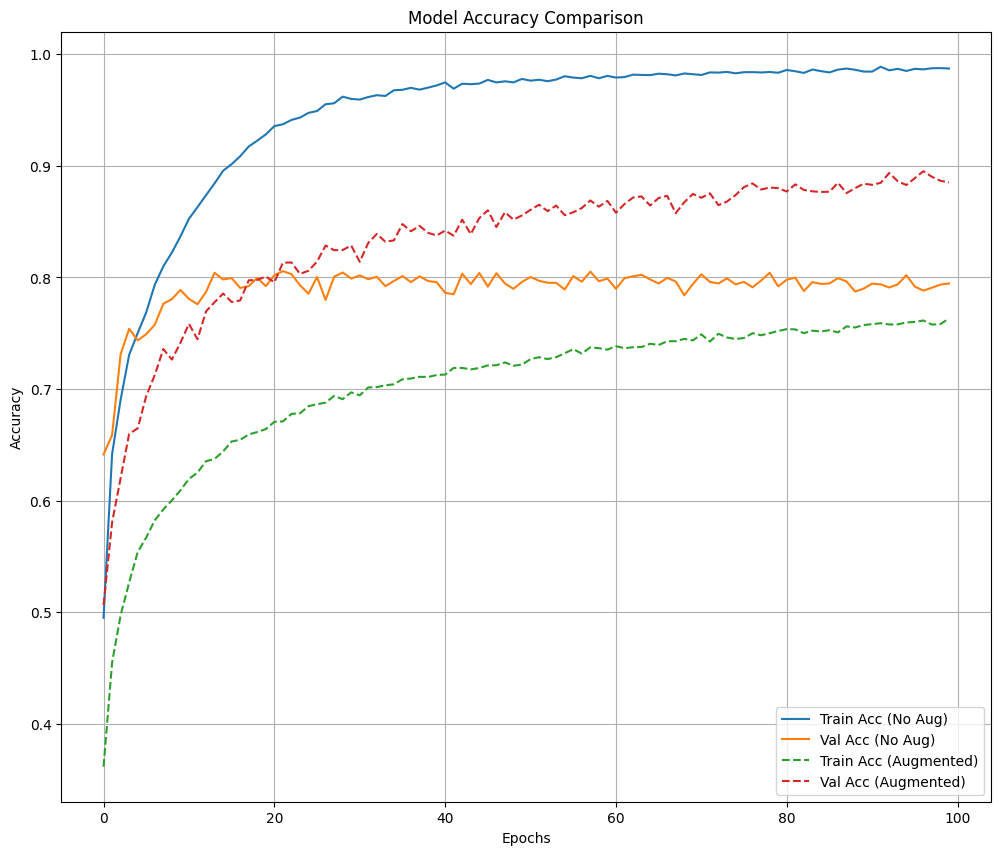

In [ ]:
# Plotting
plt.figure(figsize=(12, 10))

# Accuracy Plot

plt.plot(history_plain['train_acc'], label='Train Acc (No Aug)') # Training accuracy is now comparable
plt.plot(history_plain['val_acc'], label='Val Acc (No Aug)')
plt.plot(history_augmented['train_acc'], label='Train Acc (Augmented)', linestyle='--')
plt.plot(history_augmented['val_acc'], label='Val Acc (Augmented)', linestyle='--')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

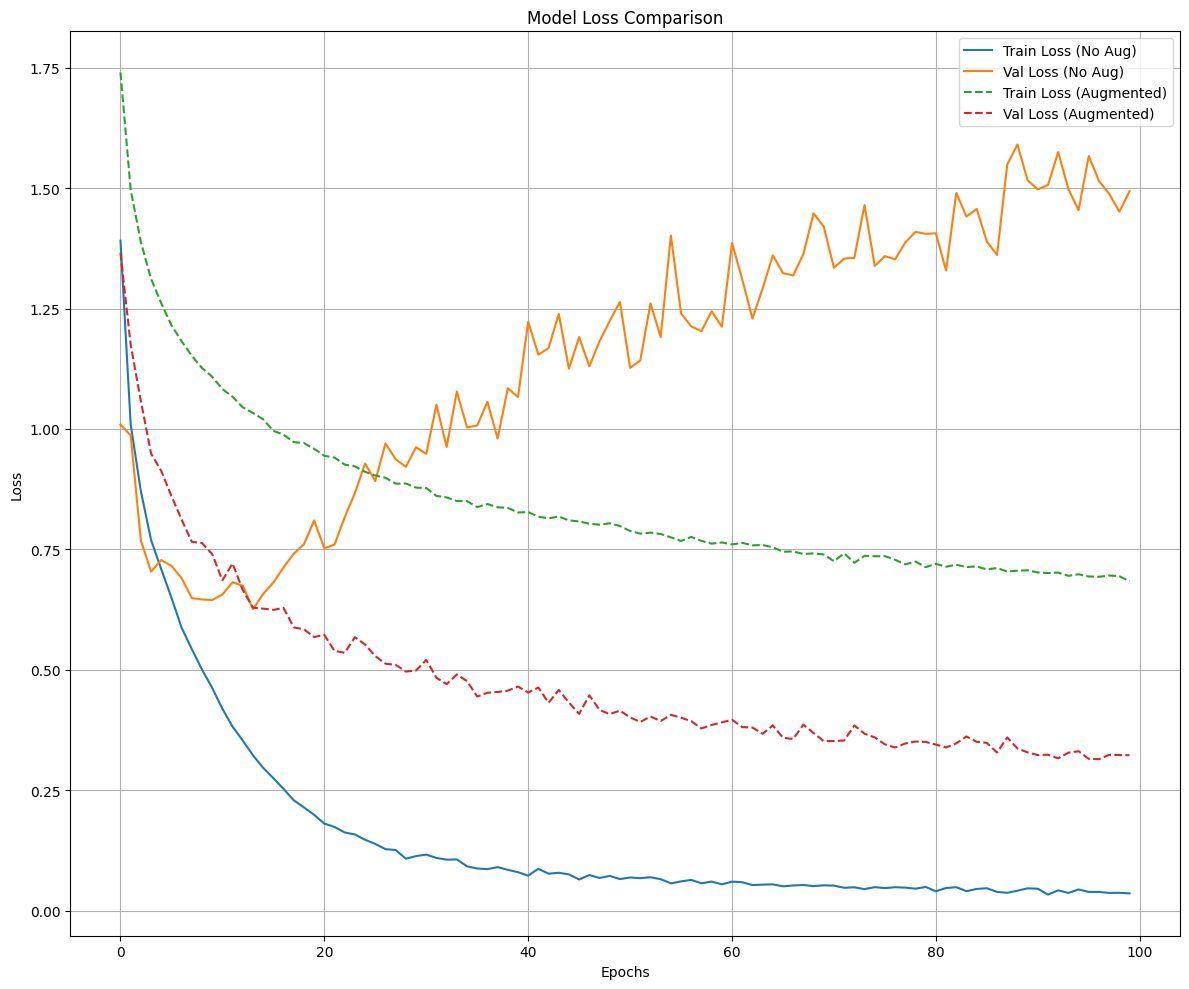


Comparison complete.
Thank you!


In [ ]:
# Loss Plot
plt.figure(figsize=(12, 10))
plt.plot(history_plain['train_loss'], label='Train Loss (No Aug)')
plt.plot(history_plain['val_loss'], label='Val Loss (No Aug)')
plt.plot(history_augmented['train_loss'], label='Train Loss (Augmented)', linestyle='--')
plt.plot(history_augmented['val_loss'], label='Val Loss (Augmented)', linestyle='--')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nComparison complete.")
print("Thank you!")